## 賃金予測モデル
東京都の地区の住宅の金額の予測モデルの構築

次元削減を考える

onehotencoding→target encoding

決定木ベースなのでlabel encodingも可能

In [432]:
# 使用ライブラリのインポート
import numpy as np
import pandas as pd
import math 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# 主成分分析ライブラリ
from sklearn.decomposition import PCA
# 標準化ライブラリ
from sklearn.preprocessing import StandardScaler
import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [433]:
df_train = pd.read_csv('train.csv') # 学習データインポート
df_test = pd.read_csv('test.csv') # テストデータインポート

In [434]:
pd.options.display.float_format = '{:.2f}'.format#pandasの有効数字表示オプション：2桁

In [435]:
# 外れ値除外関数　平均値±2σで除去 連続値データのみ
def out_lier_clear(df,df_colum,up,down):
    under_hinge = df[df_colum].describe()['25%'] # 下ヒンジ
    upper_hinge = df[df_colum].describe()['75%'] #上ヒンジ
    gap_hinge = upper_hinge - under_hinge # ヒンジ幅
    
    df_const = df[df[df_colum] > under_hinge - 1.5*gap_hinge]
    df_const = df[df[df_colum] < upper_hinge + 1.5*gap_hinge]
    
    if up == True and down == True:
        return df_const,df[df[df_colum] >= upper_hinge + 1.5*gap_hinge],df[df[df_colum] <= under_hinge - 1.5*gap_hinge] # 外れ値も出力
    elif up == True and down == False:
        return df_const,df[df[df_colum] >= upper_hinge + 1.5*gap_hinge]
    elif up == False and down == True:
        return df_const,df[df[df_colum] <= under_hinge - 1.5*gap_hinge]
    else:
        return df_const

In [436]:
df_train.head(3)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間


In [437]:
df_test.head(3)

,id,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,31471,東京都世田谷区深沢５丁目1-27,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,2LDK,49年0ヶ月,南,50.22m2,8階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...,鉄骨造,NaN
1,31472,東京都目黒区八雲１丁目11-8,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,1R,0年2ヶ月,南東,20.88m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...,"駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
2,31473,東京都豊島区池袋本町２丁目22-2,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,1K,23年4ヶ月,南東,26.93m2,1階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...,"駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...",【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...,鉄骨造,2年間


In [438]:
print(len(df_train))

31470


In [439]:
df_train.columns

Index(['id', '賃料', '所在地', 'アクセス', '間取り', '築年数', '方角', '面積', '所在階', 'バス・トイレ',
       'キッチン', '放送・通信', '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間'],
      dtype='object')

In [440]:
# 欠損値の調査
print(df_train.isnull().sum(),'\n',df_test.isnull().sum())

id           0
賃料           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2749
面積           0
所在階          0
バス・トイレ     329
キッチン       621
放送・通信     3440
室内設備        82
駐車場       5287
周辺環境      9432
建物構造         0
契約期間      7120
dtype: int64 
 id           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2808
面積           0
所在階          1
バス・トイレ     320
キッチン       635
放送・通信     3454
室内設備        73
駐車場       5356
周辺環境      9241
建物構造         0
契約期間      6981
dtype: int64


In [441]:
df_train = df_train.fillna(-1)
df_test = df_test.fillna(-1)

## 賃料の分析
外れ値の解釈

In [442]:
df_cost = df_train['賃料']

In [443]:
df_cost.describe()

count     31470.00
mean     118290.31
std       73748.80
min       25000.00
25%       76000.00
50%      102000.00
75%      136000.00
max     2500000.00
Name: 賃料, dtype: float64

In [444]:
# 外れ値処理を行ったデータ
df_cost_clear,df_cost_clear_up_lier = out_lier_clear(df_train,'賃料',True,False)
print(df_cost_clear['賃料'].describe(),df_cost_clear_up_lier['賃料'].describe())

count    29564.00
mean    105353.12
std      40153.57
min      25000.00
25%      75000.00
50%      98000.00
75%     128000.00
max     225000.00
Name: 賃料, dtype: float64 count      1906.00
mean     318959.16
std      148116.20
min      226000.00
25%      248000.00
50%      273900.00
75%      330000.00
max     2500000.00
Name: 賃料, dtype: float64


全体的に値段が高い賃貸が混ざっている（少数で引き上げている）
外れ値判定された高額物件だけを分析してみる

In [445]:
df_cost_clear_up_lier.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
18,19,310000,東京都新宿区四谷三栄町,総武線・中央線（各停）\t四ツ谷駅\t徒歩5分\t\t丸ノ内線(池袋－荻窪)\t四ツ谷駅\t...,3LDK,6年0ヶ月,-1,70.82m2,5階／11階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,IHコンロ\t／\tコンロ3口／\tシステムキッチン,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...,駐輪場\t空有,【スーパー】 228m\t【スーパー】 714m\t【コンビニ】 569m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
22,23,346000,東京都中央区佃１丁目,有楽町線\t月島駅\t徒歩6分\t\t京葉線(東京－蘇我)\t越中島駅\t徒歩11分\t\t...,2LDK,30年4ヶ月,北西,81.2m2,10階／42階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t独立キッチン,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\t24時間換気システム\t／\t...,駐輪場\t空有,-1,SRC（鉄骨鉄筋コンクリート）,-1
30,31,285000,東京都豊島区高田３丁目,副都心線\t雑司が谷駅\t徒歩7分\t\t山手線\t目白駅\t徒歩12分\t\t東京メトロ東...,2LDK,13年2ヶ月,東,92.17m2,4階／11階建（地下1階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tシステムキッチン\t／\t給湯,光ファイバー／\tCATV／\tBSアンテナ,エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...,"駐車場\t空無\t28,000円(税込)",【コンビニ】 300m\t【スーパー】 200m\t【ドラッグストア】 210m\t【公園】...,RC（鉄筋コンクリート）,5年間\t※この物件は\t定期借家\tです。
33,34,238000,東京都世田谷区等々力８丁目16-7,東急大井町線\t等々力駅\t徒歩10分\t\t東急田園都市線\t用賀駅\t徒歩25分\t\t...,3LDK,4年4ヶ月,南,80.3m2,3階／7階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\tカウンターキッチン\t／\t給湯／...,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付／\t床暖房\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／...,"駐輪場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 328m\t【スーパー】 1036m\t【スーパー】 804m\t【コンビニ】...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
47,48,237000,東京都渋谷区宇田川町,山手線\t渋谷駅\t徒歩7分\t\t銀座線\t渋谷駅\t徒歩9分\t\t半蔵門線\t渋谷駅\...,1LDK,14年1ヶ月,北東,43.69m2,11階／13階建,バス・トイレ別／\t追焚機能／\t浴室乾燥機,システムキッチン,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場／\tエレベーター,駐車場\t無,-1,RC（鉄筋コンクリート）,2年間


## 所在地の整形
一旦区だけで分ける、23区に変換

In [446]:
# 所在地の区だけ抽出
def address_arrange(df_address):
    address_list = []
    for item in df_address:
        match = re.search(r'東京都(.+)区', item)
        address_list.append(match.group(1)+"区")
    return pd.Series(address_list)

In [447]:
df_address_train = address_arrange(df_train['所在地'])
df_address_test = address_arrange(df_test['所在地'])

In [448]:
set(df_address_train.values)

{'世田谷区',
 '中央区',
 '中野区',
 '北区',
 '千代田区',
 '台東区',
 '品川区',
 '墨田区',
 '大田区',
 '文京区',
 '新宿区',
 '杉並区',
 '板橋区',
 '江戸川区',
 '江東区',
 '渋谷区',
 '港区',
 '目黒区',
 '練馬区',
 '荒川区',
 '葛飾区',
 '豊島区',
 '足立区'}

In [449]:
from sklearn.preprocessing import LabelEncoder

In [450]:
le = LabelEncoder()
decode_label = list(set(df_address_train))
encoded_train = le.fit_transform(df_address_train.values)
encoded_test = le.transform(df_address_test.values)
df_address_train = encoded_train
df_address_test = encoded_test

In [451]:
for i in decode_label:
    print(i,le.transform([i]))

文京区 [9]
葛飾区 [20]
品川区 [6]
渋谷区 [15]
板橋区 [12]
杉並区 [11]
港区 [16]
台東区 [5]
中野区 [2]
足立区 [22]
大田区 [8]
荒川区 [19]
世田谷区 [0]
江東区 [14]
墨田区 [7]
千代田区 [4]
北区 [3]
中央区 [1]
目黒区 [17]
練馬区 [18]
新宿区 [10]
江戸川区 [13]
豊島区 [21]


In [452]:
df_address_test

array([ 0, 17, 21, ...,  2,  4,  8])

In [453]:
df_train['所在地'] = df_address_train
df_test['所在地'] = df_address_test

In [454]:
address_lists = []
address_title = []
for item in set(df_address_train):
    address_title.append(item)
    address_lists.append(df_train[df_train['所在地']==item]['賃料'])

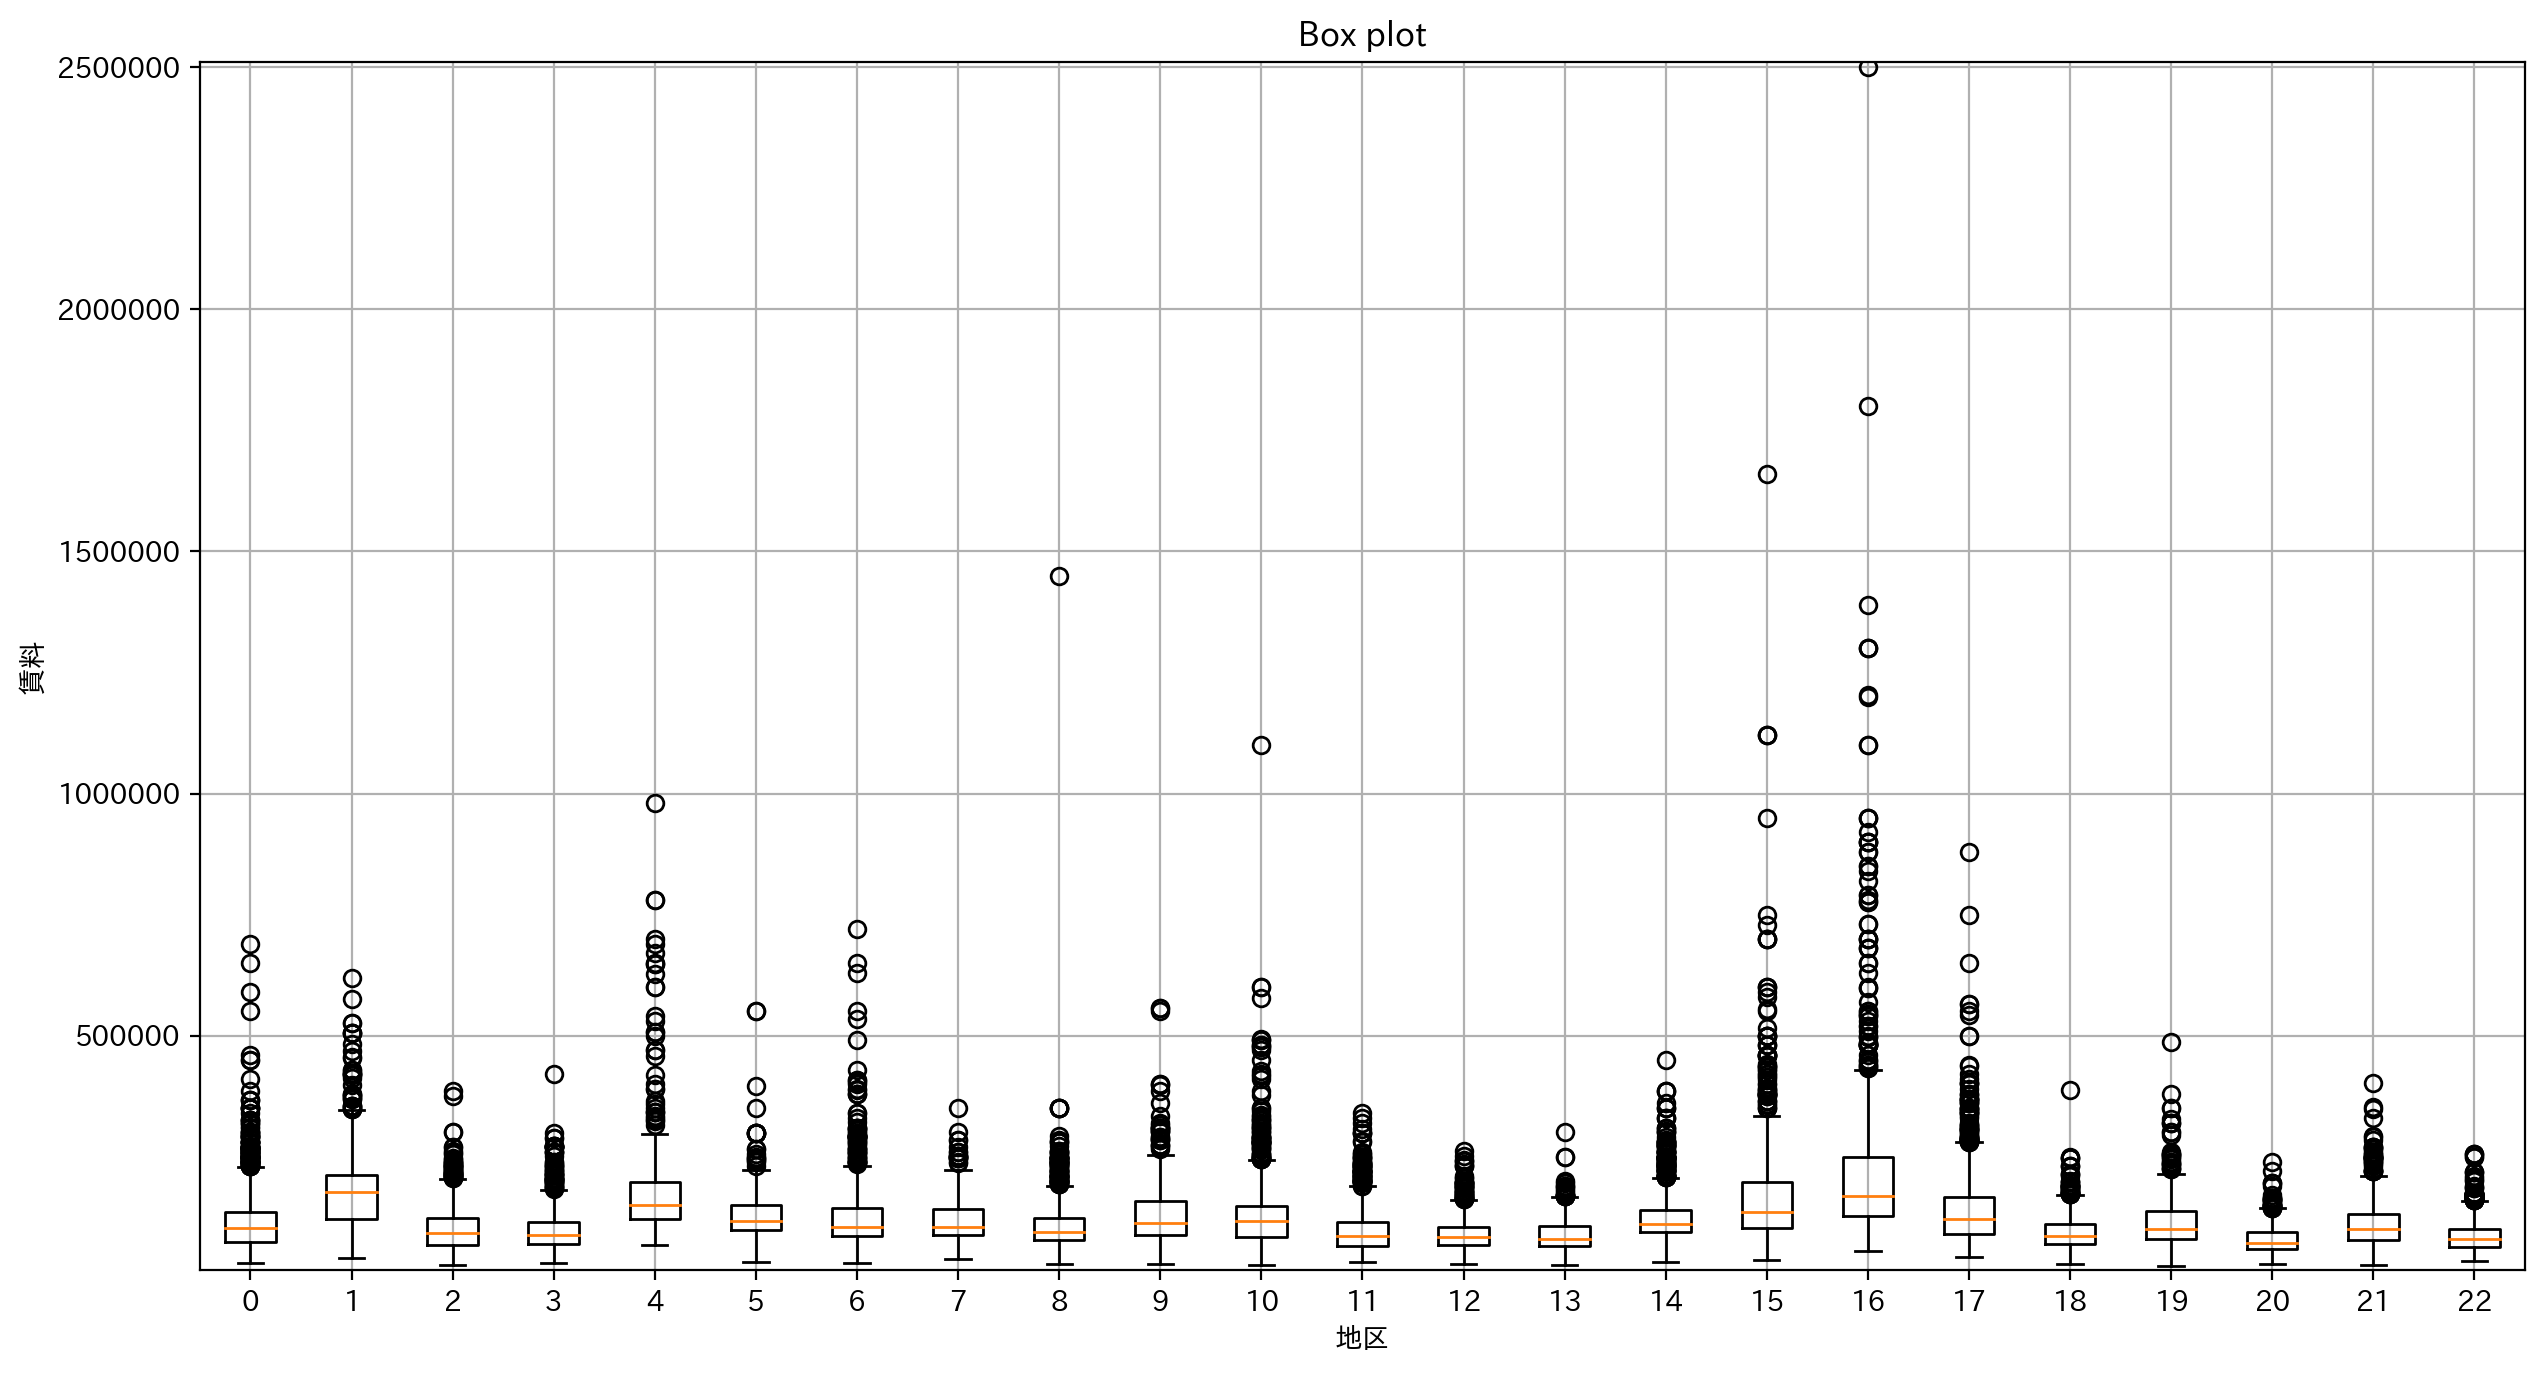

In [455]:
# 地区ごとのデータの分布を調べる
fig, ax = plt.subplots(figsize=(15,8),dpi=200)

costs = (address_lists)
bp = ax.boxplot(costs)
ax.set_xticklabels(address_title)

plt.title('Box plot')
plt.xlabel('地区')
plt.ylabel('賃料')
# Y軸のメモリのrange
plt.ylim([df_train['賃料'].min()-10000,df_train['賃料'].max()+10000])
#plt.ylim([df_train['賃料'].min()-10000,500000])
plt.grid()

# 描画
plt.show()

## アクセスの整形
最寄り駅までの時間を採用
車は大体3倍かかると計算して3倍の時間に変換

In [456]:
df_train['アクセス']

0        都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...
1        都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...
2        京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...
3        総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...
4        京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...
                               ...                        
31465    都営三田線\t蓮根駅\t徒歩7分\t\t都営三田線\t西台駅\t徒歩10分\t\t都営三田線...
31466    東急田園都市線\t三軒茶屋駅\t徒歩6分\t\t東急世田谷線\t西太子堂駅\t徒歩4分\t\...
31467    東西線\t南砂町駅\t徒歩5分\t\t都営新宿線\t大島(東京都)駅\t徒歩26分\t\t東...
31468    中央線（快速）\t中野(東京都)駅\t徒歩4分\t\t丸ノ内線(池袋－荻窪)\t新中野駅\t...
31469    有楽町線\t千川駅\t徒歩5分\t\t有楽町線\t要町駅\t徒歩13分\t\t西武池袋線\t...
Name: アクセス, Length: 31470, dtype: object

In [457]:
def arrange_access(df_access):
    access_list = []
    for item in df_access:
        access_list.append(item.split('\t\t'))

    access_list_arrange = []
    min = 100000
    for item in access_list:
        min = 100000
        for elem in item:
            elem_str = elem.replace('\t','')
            if '徒歩' not in elem_str:
                if '分' in elem_str:
                    search_num = int(re.search(r'\d+', elem_str).group())
                    if '下車' not in elem_str and '車' in elem_str: # 車移動時間
                        search_num = 3 * search_num
                else: # 欠損値で時間が書いてないので一旦100000に
                    search_num = 100000
            else:
                if '分' in elem_str:
                    search_num = int(re.search(r'\d+', elem_str).group())
                else:
                    search_num = 10 # 徒歩圏内の平均値
            if min > search_num:
                min = search_num
        access_list_arrange.append(min)
    return pd.Series(access_list_arrange)

In [458]:
df_access_train = arrange_access(df_train['アクセス'])
df_access_test = arrange_access(df_test['アクセス'])

In [459]:
print(df_access_train.describe(),'\n',df_access_test.describe())

count   31470.00
mean        7.02
std         4.17
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        42.00
dtype: float64 
 count   31262.00
mean        6.97
std         4.15
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        43.00
dtype: float64


In [460]:
print(len(df_access_train),len(df_access_test))

31470 31262


## 周辺環境の整形

In [461]:
df_train['周辺環境']

0        【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...
1                                             【スーパー】 1283m
2        【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m
3        【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...
4        【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...
                               ...                        
31465                                                   -1
31466    【スーパー】 458m\t【スーパー】 540m\t【コンビニ】 131m\t【コンビニ】 ...
31467    【コンビニ】 302m\t【コンビニ】 394m\t【コンビニ】 452m\t【コンビニ】 ...
31468    【スーパー】 485m\t【スーパー】 1051m\t【コンビニ】 476m\t【コンビニ】...
31469                                                   -1
Name: 周辺環境, Length: 31470, dtype: object

In [462]:
df_neighbor_train = df_train['周辺環境']
df_neighbor_test = df_test['周辺環境']

In [463]:
def arrange_neighbor_1(df_neighbor):
    df_neighbor_list = []
    df_neighbor_set = []
    for item in df_neighbor:
        if item != -1:
            item_list = item.split('\t')
            item_list_elem = item.split()
            df_neighbor_list.append(item_list)
            for elem in item_list_elem:
                if '【' in elem:
                    df_neighbor_set.append(elem)
        else:
            df_neighbor_list.append(-1)
    return df_neighbor_list, set(df_neighbor_set)

In [464]:
df_neighbor_train_all,df_neighbor_train_set = arrange_neighbor_1(df_train['周辺環境'])
df_neighbor_test_all,df_neighbor_test_set = arrange_neighbor_1(df_test['周辺環境'])

In [465]:
def create_dic(df_neighbor_train_set):
    df_neighbor_dic = {}
    for index in df_neighbor_train_set:
        df_neighbor_dic[index] = 0
    return df_neighbor_dic

def neighbor_arrange_dataset(df_neighbor_arrange_1,df_neighbor_set):
    neighbor_arrange = []
    for item in df_neighbor_arrange_1:
        neighbor_dic = create_dic(df_neighbor_set)
        if item != -1:
            for elem in item:
                element = elem.split()
                int_data = (-1)*int(element[1].replace('m',''))
                if neighbor_dic[element[0]] > int_data:
                    neighbor_dic[element[0]] = int_data
        neighbor_arrange.append(neighbor_dic)
    return pd.DataFrame(neighbor_arrange)

In [466]:
df_neighbor_train = neighbor_arrange_dataset(df_neighbor_train_all,df_neighbor_train_set)
df_neighbor_test = neighbor_arrange_dataset(df_neighbor_test_all,df_neighbor_test_set)

In [467]:
print(len(df_neighbor_train),len(df_neighbor_test))

31470 31262


In [468]:
df_neighbor_test.head()

,【公園】,【幼稚園・保育園】,【総合病院】,【月極駐車場】,【デパート】,【飲食店】,【コンビニ】,【郵便局】,【クリーニング】,【学校】,【コインパーキング】,【スーパー】,【銀行】,【小学校】,【レンタルビデオ】,【病院】,【ドラッグストア】,【図書館】,【大学】
0,0,0,0,0,0,0,-74,0,0,-252,0,-215,0,-219,0,-313,0,0,0
1,0,0,0,0,0,0,-374,0,0,0,0,-313,0,0,0,0,0,0,0
2,0,0,0,0,0,0,-371,0,0,0,0,-810,0,0,0,0,0,0,0
3,0,0,0,0,0,0,-489,0,0,0,0,-702,0,0,0,0,-841,0,0
4,0,0,0,0,0,0,-703,0,0,0,0,-902,-1176,0,0,0,-1166,0,0


In [469]:
def to_pca(df_train,df_test,num):
    train = df_train.values
    test = df_test.values
    #　主成分分析
    pca = PCA(n_components=num)
    # PCAは標準化した値を使う
    stdsc = StandardScaler()
    train_std = stdsc.fit_transform(train)
    test_std = stdsc.transform(test)
    train_pca_std = pca.fit_transform(train_std)
    test_pca_std = pca.transform(test_std)
    
    return train_pca_std,test_pca_std

In [470]:
train_neighbor,test_neighbor = to_pca(df_neighbor_train,df_neighbor_test,3)

In [471]:
df_train['周辺環境_0'] = train_neighbor[:,0]
df_train['周辺環境_1'] = train_neighbor[:,1]
df_train['周辺環境_2'] = train_neighbor[:,2]

df_test['周辺環境_0'] = test_neighbor[:,0]
df_test['周辺環境_1'] = test_neighbor[:,1]
df_test['周辺環境_2'] = test_neighbor[:,2]

In [472]:
df_train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,周辺環境_0,周辺環境_1,周辺環境_2
0,1,75000,3,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,5.42,2.98,0.35
1,2,76000,1,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,-1,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,-0.62,0.33,0.40
2,3,110000,15,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,-0.69,0.06,0.04
3,4,150000,11,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,-0.68,0.11,0.09
4,5,74000,20,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,-1,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,-0.66,0.36,0.19


## 方角の整形

In [473]:
df_train['方角'].unique()

array(['南東', -1, '南', '東', '北西', '西', '北', '南西', '北東'], dtype=object)

In [474]:
df_train['方角'].value_counts()

南     8909
東     4995
西     4026
南東    3098
南西    3080
-1    2749
北     1966
北西    1326
北東    1321
Name: 方角, dtype: int64

In [475]:
# 外れ値は最頻値で補完
df_train.loc[df_train['方角']==-1,'方角'] = df_train['方角'].mode()[0]
df_test.loc[df_test['方角']==-1,'方角'] = df_test['方角'].mode()[0]

In [476]:
print(df_train['方角'].value_counts(),'\n',df_test['方角'].value_counts())

南     11658
東      4995
西      4026
南東     3098
南西     3080
北      1966
北西     1326
北東     1321
Name: 方角, dtype: int64 
 南     11596
東      4948
西      4061
南東     3052
南西     3042
北      1801
北西     1416
北東     1346
Name: 方角, dtype: int64


In [477]:
# ターゲットエンコーディング
for column in df_train['方角'].unique():
    direction_mean = df_train.loc[df_train['方角']==column,'賃料'].mean()
    df_train.loc[df_train['方角']==column,'方角'] = direction_mean
    df_test.loc[df_test['方角']==column,'方角'] = direction_mean

## 所在階の整形
最高階は影響しそうなので、最高階と実際階に分ける

戸建ては戸建てラベルをつけた

地下室は一旦無視

In [478]:
df_train['所在階'].head()

0     1階／12階建
1     5階／10階建
2    12階／15階建
3      3階／4階建
4      1階／2階建
Name: 所在階, dtype: object

In [479]:
# detatch：戸建て
def arrange_floor(df_floor):
    floor_dic = {'now':1,'max':-1,'detatch':0}
    floor_arrange_list = []
    
    for item in df_floor:
        floor_dic = {'now':1,'max':-1,'detatch':0}
        if item != -1:
            str_list = item.split('／') 
            if len(str_list) == 2:
                if len(str_list[0]) < 1:
                    floor_dic['now'] = -1
                else:
                    floor_dic['now'] = int(re.search(r'\d+', str_list[0])[0])
                if len(str_list[1]) < 1:
                    floor_dic['max'] = -1
                else:
                    floor_dic['max'] = int(re.search(r'\d+', str_list[1])[0])
            else:
                floor_dic['detatch'] = 1
                floor_dic['now'] = int(re.search(r'\d+', str_list[0])[0])

            floor_arrange_list.append(floor_dic)

    return pd.DataFrame(floor_arrange_list)

In [480]:
df_floor_train = arrange_floor(df_train['所在階'])
df_floor_test = arrange_floor(df_test['所在階'])

In [481]:
df_floor_train.head()

,now,max,detatch
0,1,12,0
1,5,10,0
2,12,15,0
3,3,4,0
4,1,2,0


In [482]:
df_train['所在階'] = round(df_floor_train['now']/df_floor_train['max'],3)
df_test['所在階'] = round(df_floor_test['now']/df_floor_test['max'],3)

In [483]:
df_train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,周辺環境_0,周辺環境_1,周辺環境_2
0,1,75000,3,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,131210.77,20.01m2,0.08,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,5.42,2.98,0.35
1,2,76000,1,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,110610.19,16.5m2,0.50,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,-0.62,0.33,0.40
2,3,110000,15,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,110610.19,22.05m2,0.80,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,-0.69,0.06,0.04
3,4,150000,11,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,110610.19,60.48m2,0.75,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,-0.68,0.11,0.09
4,5,74000,20,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,110610.19,39.66m2,0.50,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,-1,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,-0.66,0.36,0.19


In [484]:
df_train['所在階'].loc[df_train['所在階']==-1] = 0
df_test['所在階'].loc[df_test['所在階']==-1] = 0
#df_train['所在階'].fillna(-1)
#df_test['所在階'].fillna(-1)

C:\Users\k31m0\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [485]:
df_test.head()

,id,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,周辺環境_0,周辺環境_1,周辺環境_2
0,31471,0,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,2LDK,49年0ヶ月,110610.19,50.22m2,1.00,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...,鉄骨造,-1,0.62,-1.09,-0.35
1,31472,17,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,1R,0年2ヶ月,131210.77,20.88m2,0.75,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...,"駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,-0.70,-0.16,-0.04
2,31473,21,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,1K,23年4ヶ月,131210.77,26.93m2,0.25,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...,"駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...",【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...,鉄骨造,2年間,-0.66,0.37,0.19
3,31474,11,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩10分\t\t京王線\t代田橋駅\t徒歩8分...,1K,36年2ヶ月,131210.77,23.57m2,0.50,シャワー,ガスコンロ／\t給湯,-1,エアコン付\tシューズボックス／\t2面採光／\t室外洗濯機置場\t公営水道／\t下水／\t...,駐輪場\t空有\t0円,【スーパー】 286m\t【スーパー】 702m\t【コンビニ】 489m\t【コンビニ】 ...,木造,2年間,-0.35,1.76,-0.08
4,31475,11,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩12分\t\t丸ノ内線(池袋－荻窪)\t新高...,2LDK,45年4ヶ月,110610.19,50m2,1.00,専用バス／\t専用トイレ／\tバス・トイレ別,コンロ設置可（口数不明）／\t給湯,インターネット対応,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置...,"駐車場\t近隣\t22,600円\t距離177m",【コンビニ】 312m\t【コンビニ】 436m\t【スーパー】 902m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,0.67,4.70,-0.96


In [486]:
df_floor_test.head()

,now,max,detatch
0,8,8,0
1,3,4,0
2,1,4,0
3,1,2,0
4,4,4,0


In [487]:
print(len(df_floor_train),'\n',len(df_floor_test))

31470 
 31261


## 築年数の整数値に変換
築年数を数値に変換　1年→12ヶ月　

In [488]:
df_train['築年数'].head()

0      9年9ヶ月
1    44年10ヶ月
2      8年6ヶ月
3     29年4ヶ月
4     31年7ヶ月
Name: 築年数, dtype: object

In [489]:
# ○年○ヶ月をint型の定数に変換
def str_to_int(df):
    build_year_list = []
    for item in df:
        match = re.findall(r'\d+',item)
        if item == '新築':
            match = [0,0]
        if int(match[0])*12 + int(match[1]) > 10000:
            build_year_list.append(-1) # はずれ値は-1にしておく
        else:
            build_year_list.append(int(match[0])*12 + int(match[1]))
    return pd.Series(build_year_list)

In [490]:
df_build_year_train = str_to_int(df_train['築年数'])
df_build_year_test = str_to_int(df_test['築年数'])

In [491]:
print(df_build_year_train.describe(),df_build_year_test.describe())

count   31470.00
mean      193.95
std       168.29
min        -1.00
25%        41.00
50%       161.00
75%       329.00
max      6245.00
dtype: float64 count   31262.00
mean      195.39
std       165.24
min         0.00
25%        43.00
50%       161.00
75%       330.00
max      1336.00
dtype: float64


In [492]:
# 外れ値 多分入力ミス
df_train[df_train['築年数']=='1019年7ヶ月']

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,周辺環境_0,周辺環境_1,周辺環境_2
20427,20428,82000,17,東急東横線\t祐天寺駅\t徒歩11分\t\t東急東横線\t中目黒駅\t徒歩15分\t\t東急...,1DK,1019年7ヶ月,110610.19,24m2,1.00,専用トイレ／\tバス・トイレ別／\tシャワー,コンロ設置可（コンロ2口）,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室外洗濯機置場／\tタ...,-1,-1,鉄骨造,-1,-0.73,-1.06,-0.19


## 面積を実数値に変換
外れ値はなし

In [493]:
print(df_train['面積'].head(),df_test['面積'].head())
print(df_train['面積'].isnull().sum(),df_test['面積'].isnull().sum())

0    20.01m2
1     16.5m2
2    22.05m2
3    60.48m2
4    39.66m2
Name: 面積, dtype: object 0    50.22m2
1    20.88m2
2    26.93m2
3    23.57m2
4       50m2
Name: 面積, dtype: object
0 0


In [494]:
def arrange_area(df_area):
    area_list = []
    for item in df_area:
        num_str = item.replace('m2','')
        area_list.append(float(num_str))
    
    return pd.Series(area_list)

In [495]:
df_area_train = arrange_area(df_train['面積'])
df_area_test = arrange_area(df_test['面積'])

(array([  131.,  4460., 11861.,  4861.,  4478.,  2621.,  1389.,   639.,
          357.,   171.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

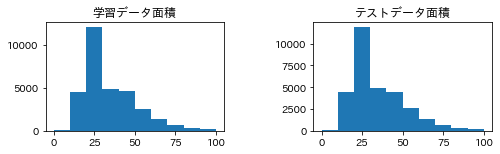

In [496]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax1.set_title('学習データ面積')
ax1.hist(df_area_train,bins=10,range=(0,100))

ax2.set_title('テストデータ面積')
ax2.hist(df_area_test,bins=10,range=(0,100))

In [497]:
print(df_area_train.describe(),df_area_test.describe())

count   31470.00
mean       34.81
std        18.81
min         4.86
25%        22.44
50%        28.41
75%        42.39
max       430.10
dtype: float64 count   31262.00
mean       34.86
std        18.90
min         1.00
25%        22.28
50%        28.49
75%        42.60
max       407.61
dtype: float64


## 建物構造の整形
外れ値なし
とりあえずこのままいくか
賃料との分布を見てまとめてもいいかも

In [498]:
df_train['建物構造'].head()

0    RC（鉄筋コンクリート）
1             鉄骨造
2    RC（鉄筋コンクリート）
3    RC（鉄筋コンクリート）
4              木造
Name: 建物構造, dtype: object

In [499]:
print(df_train['建物構造'].unique(),'\n',df_test['建物構造'].unique())
# 鉄筋ブロックが学習データからリーク

['RC（鉄筋コンクリート）' '鉄骨造' '木造' 'SRC（鉄骨鉄筋コンクリート）' '軽量鉄骨' 'ALC（軽量気泡コンクリート）'
 'その他' 'PC（プレキャスト・コンクリート（鉄筋コンクリート））' 'HPC（プレキャスト・コンクリート（重量鉄骨））' 'ブロック'] 
 ['鉄骨造' 'RC（鉄筋コンクリート）' '木造' 'SRC（鉄骨鉄筋コンクリート）' '軽量鉄骨' 'ALC（軽量気泡コンクリート）'
 'その他' 'HPC（プレキャスト・コンクリート（重量鉄骨））' 'PC（プレキャスト・コンクリート（鉄筋コンクリート））' '鉄筋ブロック'
 'ブロック']


In [500]:
df_train_sutruct = df_cost_clear[['建物構造','賃料']]

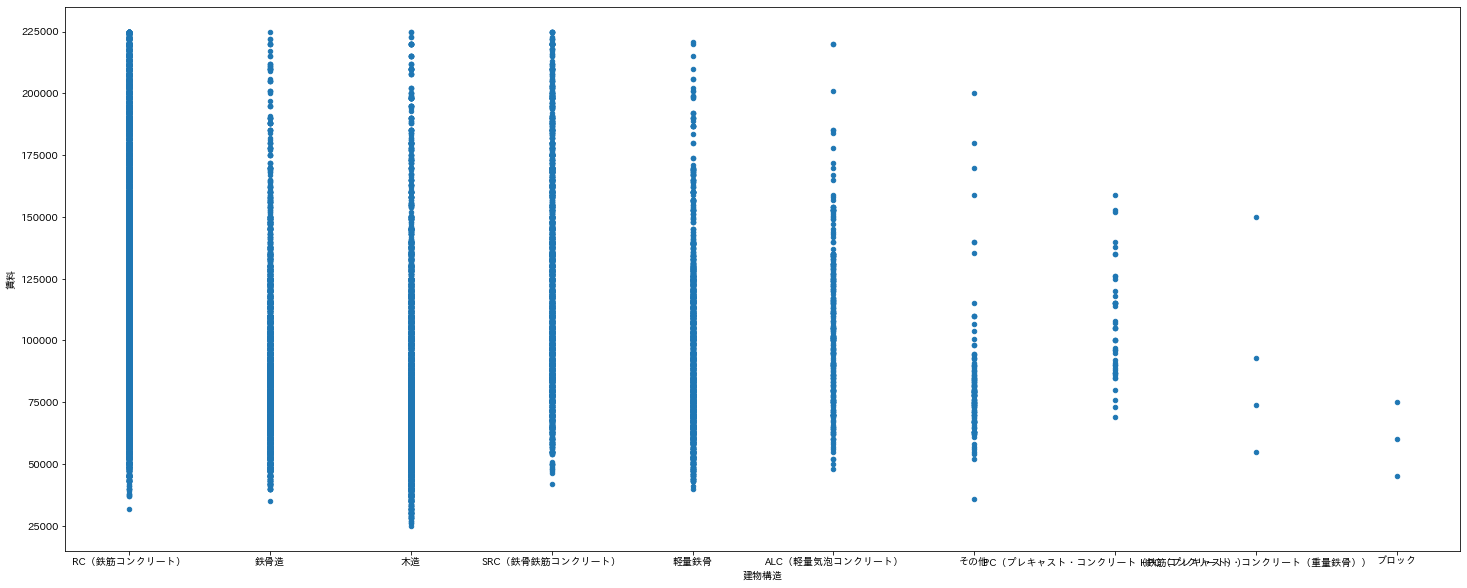

In [501]:
df_train_sutruct.plot.scatter(x='建物構造', y='賃料',figsize=(25,10))

In [502]:
# ターゲットエンコーディング
for column in df_train['建物構造'].unique():
    mean_struct = df_train.loc[df_train['建物構造']==column,'賃料'].mean()
    df_train.loc[df_train['建物構造']==column,'建物構造'] = mean_struct
    df_test.loc[df_test['建物構造']==column,'建物構造'] = mean_struct

In [503]:
df_test.loc[df_test['建物構造']=='鉄筋ブロック','建物構造'] = df_train['賃料'].mean()

In [504]:
df_test['建物構造'].unique()

array([91993.97101449275, 134366.13470437017, 83823.20228592162,
       142525.4083985179, 94458.1600441501, 107103.70370370371,
       81724.44852941176, 93000.0, 106195.65217391304, 118290.30641881157,
       60000.0], dtype=object)

## 契約期間の整形
定期借家は一旦無視　単純な契約期間で考える
外れ値あり

In [505]:
print(df_train['契約期間'])

0                           2年間
1                           2年間
2                           2年間
3        2年間\t※この物件は\t定期借家\tです。
4                           2年間
                  ...          
31465                       2年間
31466                       2年間
31467                       2年間
31468                       2年間
31469                       2年間
Name: 契約期間, Length: 31470, dtype: object


In [506]:
def str_to_int_span(df):
    build_span_list = []
    for item in df:
        if item == -1: # 外れ値のとき
            build_span_list.append(-1)
        else:
            match = re.findall(r'\d+',item)
            if len(match) == 1:
                match.append(0)
            elif int(match[0]) > 2000:
                arrange_span = (int(match[0]) * 12 + int(match[1])) - (2019 * 12 + 8)
                match[0],match[1] = int(arrange_span / 12),arrange_span % 12
            if (int(match[0]) * 12 + int(match[1])) > 100:
                print(item)
            build_span_list.append(int(match[0])*12 + int(match[1]))
    return pd.Series(build_span_list)

In [507]:
df_span_train = str_to_int_span(df_train['契約期間'])
df_span_test = str_to_int_span(df_test['契約期間'])
print(df_span_train,'\n')
print(df_span_test)

22年間
12年間
10年間	※この物件は	定期借家	です。
10年間	※この物件は	定期借家	です。
9ヶ月間	※この物件は	定期借家	です。
10年間	※この物件は	定期借家	です。
10年間	※この物件は	定期借家	です。
10年間	※この物件は	定期借家	です。
22年間
10年間	※この物件は	定期借家	です。
10年間	※この物件は	定期借家	です。
15年間
15年間
10ヶ月間	※この物件は	定期借家	です。
10ヶ月間	※この物件は	定期借家	です。
0        24
1        24
2        24
3        24
4        24
         ..
31465    24
31466    24
31467    24
31468    24
31469    24
Length: 31470, dtype: int64 

0        -1
1        24
2        24
3        24
4        24
         ..
31257    24
31258    -1
31259    24
31260    -1
31261    -1
Length: 31262, dtype: int64


In [508]:
print(df_span_train.unique(),'\n',df_span_test.unique())

[ 24  -1  12  60  36  48  20  43  31   7  18 264 144  10  56  23  34  19
  28  39  35  30  22   9  84 120  17   4  25  72  50  67  55  33  61  57
 108  11   6  54  45  21  16  42   5  37 180] 
 [ -1  24  48  60  36  12  19  43  18 180   9  72  84 120  28  54   5  20
   7  34  52  31  33  10  35  50  55   6  56  37  30  66   3  15  17  57
  25   4  22  16  47]


In [509]:
print(df_span_train.describe(),'\n',df_span_test.describe())

count   31470.00
mean       18.79
std        11.69
min        -1.00
25%        24.00
50%        24.00
75%        24.00
max       264.00
dtype: float64 
 count   31262.00
mean       18.85
std        11.43
min        -1.00
25%        24.00
50%        24.00
75%        24.00
max       180.00
dtype: float64


## 間取りの整形
間取りをある程度絞ってみる
1. 頭文字の部屋数で分類
2. K,R,L,D,Sを持つかどうかで分類

In [510]:
print(df_train['間取り'],'\n',df_test['間取り'])

0          1K
1          1R
2          1K
3        2LDK
4         2DK
         ... 
31465     2DK
31466      1R
31467     3DK
31468     1DK
31469      1K
Name: 間取り, Length: 31470, dtype: object 
 0        2LDK
1          1R
2          1K
3          1K
4        2LDK
         ... 
31257      1K
31258      1R
31259    1LDK
31260      1K
31261      1K
Name: 間取り, Length: 31262, dtype: object


In [511]:
def madori_arrange(df_madori):
    madori_list = []
    for item in df_madori:
        one_list = {'room':0,'R':0,'L':0,'D':0,'K':0,'S':0}
        one_list['room'] = int(item[0])
        if 'K' in item:
            one_list['K'] = 1
        if 'R' in item:
            one_list['R'] = 1
        if 'L' in item:
            one_list['L'] = 1
        if 'D' in item:
            one_list['D'] = 1
        if 'S' in item:
            one_list['S'] = 1
        madori_list.append(one_list)
    return pd.DataFrame(madori_list)

In [512]:
df_madori_train = madori_arrange(df_train['間取り'])
df_madori_test = madori_arrange(df_test['間取り'])

In [513]:
df_madori_train.head()

,room,R,L,D,K,S
0,1,0,0,0,1,0
1,1,1,0,0,0,0
2,1,0,0,0,1,0
3,2,0,1,1,1,0
4,2,0,0,1,1,0


In [514]:
df_madori_test.head()

,room,R,L,D,K,S
0,2,0,1,1,1,0
1,1,1,0,0,0,0
2,1,0,0,0,1,0
3,1,0,0,0,1,0
4,2,0,1,1,1,0


## バス・トイレ、キッチン、放送・通信、室内設備の整形
各要素の有無をダミー変数に変換するために、/で分割して配列に直す

In [515]:
df_train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,周辺環境_0,周辺環境_1,周辺環境_2
0,1,75000,3,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,131210.77,20.01m2,0.08,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,134366.13,2年間,5.42,2.98,0.35
1,2,76000,1,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,110610.19,16.5m2,0.50,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,91993.97,2年間,-0.62,0.33,0.40
2,3,110000,15,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,110610.19,22.05m2,0.80,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,134366.13,2年間,-0.69,0.06,0.04
3,4,150000,11,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,110610.19,60.48m2,0.75,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,134366.13,2年間\t※この物件は\t定期借家\tです。,-0.68,0.11,0.09
4,5,74000,20,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,110610.19,39.66m2,0.50,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,-1,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,83823.20,2年間,-0.66,0.36,0.19


In [516]:
def init_dic(set_list):
    dic = {}
    for item in set_list:
        dic[item] = 0
    return dic

def arrange_slash_data(df):
    data_list = []
    for row in df:
        if(isinstance(row, str)):
            str_row = row.replace('／','')
            data_list.append(str_row.split())
        else:
            data_list.append('N')
    
    set_data = set()
    for item in data_list:
        for elem in item:
            set_data.add(elem)
    set_data.remove('N')
    
    list_arrange = []
    for item in df:
        dic_list = init_dic(set_data)
        if isinstance(item, str):
            for elem in set_data:
                if elem in item:
                    dic_list[elem] = 1
        list_arrange.append(dic_list)
    
    return pd.DataFrame(list_arrange)

In [517]:
df_wc_train = arrange_slash_data(df_train['バス・トイレ'])
df_kitchen_train = arrange_slash_data(df_train['キッチン'])
df_communication_train = arrange_slash_data(df_train['放送・通信'])
df_facility_train = arrange_slash_data(df_train['室内設備'])

df_wc_test = arrange_slash_data(df_test['バス・トイレ'])
df_kitchen_test = arrange_slash_data(df_test['キッチン'])
df_communication_test = arrange_slash_data(df_test['放送・通信'])
df_facility_test = arrange_slash_data(df_test['室内設備'])

In [518]:
# 各項目の頻度
def frequency(df):
    for column in df.columns:
        print(column,len(df[df[column]==1]))

In [519]:
df_wc_train.head()

,追焚機能,共同バス,専用バス,温水洗浄便座,共同トイレ,バス・トイレ別,脱衣所,専用トイレ,洗面台独立,バスなし,シャワー,浴室乾燥機
0,0,0,1,1,0,1,0,1,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0,1,0
2,0,0,1,1,0,1,1,1,1,0,1,1
3,0,0,1,1,0,1,0,1,1,0,1,0
4,1,0,1,0,0,1,0,1,0,0,1,0


In [520]:
frequency(df_wc_train)
print("---------------")
frequency(df_wc_test)

追焚機能 11989
共同バス 34
専用バス 23782
温水洗浄便座 17545
共同トイレ 86
バス・トイレ別 26458
脱衣所 12361
専用トイレ 23465
洗面台独立 20237
バスなし 141
シャワー 28242
浴室乾燥機 16337
---------------
追焚機能 11867
共同バス 21
専用バス 23461
温水洗浄便座 17313
共同トイレ 64
バス・トイレ別 26293
脱衣所 12186
トイレなし 1
専用トイレ 23220
洗面台独立 19934
バスなし 146
シャワー 28005
浴室乾燥機 16071


In [521]:
df_wc_train = df_wc_train.drop(['バスなし','共同トイレ','共同バス'],axis=1)
df_wc_test = df_wc_test.drop(['トイレなし','バスなし','共同トイレ','共同バス'],axis=1)

In [522]:
train_wc,test_wc = to_pca(df_wc_train,df_wc_test,3)

In [523]:
df_train['バス・トイレ_pca_0'] = train_wc[:,0]
df_train['バス・トイレ_pca_1'] = train_wc[:,1]
df_train['バス・トイレ_pca_2'] = train_wc[:,2]

df_test['バス・トイレ_pca_0'] = test_wc[:,0]
df_test['バス・トイレ_pca_1'] = test_wc[:,1]
df_test['バス・トイレ_pca_2'] = test_wc[:,2]

In [524]:
df_kitchen_train.head()

,ガスコンロ,コンロ1口,コンロ設置可（コンロ3口）,給湯,コンロ設置可（コンロ2口）,コンロ設置可（コンロ1口）,IHコンロ,システムキッチン,冷蔵庫あり,独立キッチン,コンロ4口以上,L字キッチン,電気コンロ,コンロ2口,カウンターキッチン,コンロ設置可（コンロ4口以上）,コンロ3口,コンロ設置可（口数不明）
0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [525]:
frequency(df_kitchen_train)
print(len(df_kitchen_train.columns))
print("----------------")
frequency(df_kitchen_test)
print(len(df_kitchen_test.columns))

ガスコンロ 20369
コンロ1口 3235
コンロ設置可（コンロ3口） 154
給湯 26368
コンロ設置可（コンロ2口） 1284
コンロ設置可（コンロ1口） 179
IHコンロ 4431
システムキッチン 20534
冷蔵庫あり 677
独立キッチン 3907
コンロ4口以上 51
L字キッチン 309
電気コンロ 525
コンロ2口 16228
カウンターキッチン 3724
コンロ設置可（コンロ4口以上） 1
コンロ3口 5547
コンロ設置可（口数不明） 484
18
----------------
コンロ1口 3146
コンロ設置可（コンロ3口） 182
給湯 26095
コンロ設置可（コンロ2口） 1271
コンロ設置可（コンロ1口） 185
IHコンロ 4420
システムキッチン 20465
冷蔵庫あり 659
コンロ3口 5502
独立キッチン 3882
コンロ4口以上 48
L字キッチン 268
電気コンロ 519
コンロ2口 15986
カウンターキッチン 3754
コンロ設置可（コンロ4口以上） 1
ガスコンロ 20179
コンロ設置可（口数不明） 436
18


In [526]:
df_kitchen_train = df_kitchen_train.drop(['L字キッチン','コンロ設置可（コンロ2口）','コンロ設置可（コンロ4口以上）','コンロ設置可（コンロ3口）','コンロ4口以上','コンロ設置可（口数不明）','コンロ設置可（コンロ1口）'],axis=1)
df_kitchen_test = df_kitchen_test.drop(['L字キッチン','コンロ設置可（コンロ2口）','コンロ設置可（コンロ4口以上）','コンロ設置可（コンロ3口）','コンロ4口以上','コンロ設置可（口数不明）','コンロ設置可（コンロ1口）'],axis=1)

In [527]:
train_kitchen,test_kitchen = to_pca(df_kitchen_train,df_kitchen_test,3)

In [528]:
df_train['キッチン_pca_0'] = train_kitchen[:,0]
df_train['キッチン_pca_1'] = train_kitchen[:,1]
df_train['キッチン_pca_2'] = train_kitchen[:,2]

df_test['キッチン_pca_0'] = test_kitchen[:,0]
df_test['キッチン_pca_1'] = test_kitchen[:,1]
df_test['キッチン_pca_2'] = test_kitchen[:,2]

In [529]:
df_communication_train.head()

,CATV,光ファイバー,インターネット対応,CSアンテナ,高速インターネット,BSアンテナ,インターネット使用料無料,有線放送
0,1,0,1,1,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,1,1,1,0,1,0,0
3,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [530]:
frequency(df_communication_train)
print("---------------")
frequency(df_communication_test)

CATV 13083
光ファイバー 16306
インターネット対応 17193
CSアンテナ 9291
高速インターネット 2498
BSアンテナ 13453
インターネット使用料無料 5404
有線放送 72
---------------
CATV 12971
光ファイバー 16290
インターネット対応 16997
CSアンテナ 9211
高速インターネット 2469
BSアンテナ 13406
インターネット使用料無料 5258
有線放送 84


In [531]:
#　有線放送削除
df_communication_train = df_communication_train.drop(['有線放送'],axis=1)
df_communication_test= df_communication_test.drop(['有線放送'],axis=1)

In [532]:
train_communication,test_communication = to_pca(df_communication_train,df_communication_test,2)

In [533]:
df_train['通信_pca_0'] = train_communication[:,0]
df_train['通信_pca_1'] = train_communication[:,1]

df_test['通信_pca_0'] = test_communication[:,0]
df_test['通信_pca_1'] = test_communication[:,1]

In [534]:
df_facility_train.head()

,地下室,3面採光,2面採光,都市ガス,出窓,タイル張り,床暖房,エアコン付,敷地内ごみ置き場,オール電化,...,トランクルーム,二重サッシ,ルーフバルコニー,ウォークインクローゼット,バリアフリー,クッションフロア,二世帯住宅,専用庭,汲み取り,フローリング
0,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [535]:
frequency(df_facility_train)
print(len(df_facility_train.columns))
print('----------------------------')
frequency(df_facility_train)
print(len(df_facility_train.columns))

地下室 7
3面採光 1046
2面採光 6636
都市ガス 25533
出窓 1314
タイル張り 13677
床暖房 1635
エアコン付 29746
敷地内ごみ置き場 16746
オール電化 549
浄化槽 10
室外洗濯機置場 1695
公営水道 23242
24時間換気システム 10704
ロフト付き 1241
ガス暖房 2
ガスその他 16
下水 23415
エレベーター 16148
水道その他 1685
石油暖房 1
洗濯機置場なし 69
バルコニー 25140
室内洗濯機置場 27389
井戸 1
冷房 5179
シューズボックス 22947
プロパンガス 1010
防音室 61
床下収納 587
ペアガラス 597
排水その他 9
トランクルーム 504
二重サッシ 87
ルーフバルコニー 316
ウォークインクローゼット 3848
バリアフリー 157
クッションフロア 394
二世帯住宅 3
専用庭 215
汲み取り 5
フローリング 27274
42
----------------------------
地下室 7
3面採光 1046
2面採光 6636
都市ガス 25533
出窓 1314
タイル張り 13677
床暖房 1635
エアコン付 29746
敷地内ごみ置き場 16746
オール電化 549
浄化槽 10
室外洗濯機置場 1695
公営水道 23242
24時間換気システム 10704
ロフト付き 1241
ガス暖房 2
ガスその他 16
下水 23415
エレベーター 16148
水道その他 1685
石油暖房 1
洗濯機置場なし 69
バルコニー 25140
室内洗濯機置場 27389
井戸 1
冷房 5179
シューズボックス 22947
プロパンガス 1010
防音室 61
床下収納 587
ペアガラス 597
排水その他 9
トランクルーム 504
二重サッシ 87
ルーフバルコニー 316
ウォークインクローゼット 3848
バリアフリー 157
クッションフロア 394
二世帯住宅 3
専用庭 215
汲み取り 5
フローリング 27274
42


In [536]:
df_facility_train = df_facility_train.drop(['ガスその他','石油暖房','ガス暖房','洗濯機置場なし','二重サッシ','二世帯住宅','地下室','浄化槽','バリアフリー','汲み取り','専用庭','排水その他','防音室','井戸'],axis=1)

In [537]:
df_facility_test = df_facility_test.drop(['ガスその他','石油暖房','ガス暖房','洗濯機置場なし','二重サッシ','二世帯住宅','地下室','浄化槽','バリアフリー','汲み取り','専用庭','排水その他','防音室','井戸'],axis=1)

In [538]:
train_facilty,test_facility = to_pca(df_facility_train,df_facility_test,3)

In [539]:
df_train['設備_pca_0'] = train_facilty[:,0]
df_train['設備_pca_1'] = train_facilty[:,1]
df_train['設備_pca_2'] = train_facilty[:,2]

df_test['設備_pca_0'] = test_facility[:,0]
df_test['設備_pca_1'] = test_facility[:,1]
df_test['設備_pca_2'] = test_facility[:,2]

## 整形したデータをDataFrameに戻す

In [540]:
df_train.head(1)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,バス・トイレ_pca_1,バス・トイレ_pca_2,キッチン_pca_0,キッチン_pca_1,キッチン_pca_2,通信_pca_0,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2
0,1,75000,3,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,131210.77,20.01m2,0.08,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,...,-0.61,0.03,-1.03,-1.08,0.16,1.80,0.33,-0.95,-0.11,-0.64


＜Series型＞
カラム指定でそのまま代入

df_build_year_train：築年数

df_area_train：面積

df_span_train：契約期間

df_access_train：アクセス

＜DataFrame型＞
該当カラムを削除してdf_trainにconcat（結合）

df_neighbor_train：周辺環境

df_madori_train：間取り

df_wc_train：バス・トイレ

df_facility_train：室内設備

df_kitchen_train：キッチン

df_floor_train：所在階（整形済み、操作なし）

df_communication：放送・通信

In [92]:
df_train['築年数'] = df_build_year_train
df_train['面積'] = df_area_train
df_train['契約期間'] = df_span_train
df_train['アクセス'] = df_access_train
df_train = pd.concat([df_train,df_madori_train,df_wc_train,df_facility_train,df_kitchen_train,df_communication_train,df_neighbor_train],axis=1)

df_test['築年数'] = df_build_year_test
df_test['面積'] = df_area_test
df_test['契約期間'] = df_span_test
df_test['アクセス'] = df_access_test
df_test = pd.concat([df_test,df_madori_test,df_wc_test,df_facility_test,df_kitchen_test,df_communication_test,df_neighbor_test],axis=1)

In [541]:
# 次元削減
df_train['築年数'] = df_build_year_train
df_train['面積'] = df_area_train
df_train['契約期間'] = df_span_train
df_train['アクセス'] = df_access_train
df_train = pd.concat([df_train,df_madori_train],axis=1)

df_test['築年数'] = df_build_year_test
df_test['面積'] = df_area_test
df_test['契約期間'] = df_span_test
df_test['アクセス'] = df_access_test
df_test = pd.concat([df_test,df_madori_test],axis=1)

In [542]:
#　ダミーを作ったカラムは消去
df_train = df_train.drop(['バス・トイレ','キッチン','室内設備','間取り','放送・通信','周辺環境'],axis=1)
df_test = df_test.drop(['バス・トイレ','キッチン','室内設備','間取り','放送・通信','周辺環境'],axis=1)

In [543]:
# 使用しない特徴量を削減
df_train = df_train.drop(['駐車場'],axis=1)
df_test = df_test.drop(['駐車場'],axis=1)

In [544]:
df_train.head()

,id,賃料,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,1,75000,3,4,117,131210.77,20.01,0.08,134366.13,24,...,0.33,-0.95,-0.11,-0.64,1,0,0,0,1,0
1,2,76000,1,5,538,110610.19,16.50,0.50,91993.97,24,...,1.03,0.44,2.63,-0.73,1,1,0,0,0,0
2,3,110000,15,6,102,110610.19,22.05,0.80,134366.13,24,...,0.15,-1.96,0.59,-0.42,1,0,0,0,1,0
3,4,150000,11,3,352,110610.19,60.48,0.75,134366.13,24,...,0.14,0.05,-0.93,-0.66,2,0,1,1,1,0
4,5,74000,20,5,379,110610.19,39.66,0.50,83823.20,24,...,-0.08,2.09,-0.24,-1.12,2,0,0,1,1,0


In [545]:
df_test.head()

,id,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,周辺環境_0,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,31471,0,15,588,110610.19,50.22,1.00,91993.97,-1,0.62,...,1.03,1.76,-1.05,-0.26,2,0,1,1,1,0
1,31472,17,6,2,131210.77,20.88,0.75,134366.13,24,-0.70,...,2.61,2.20,-1.03,-1.11,1,1,0,0,0,0
2,31473,21,10,280,131210.77,26.93,0.25,91993.97,24,-0.66,...,-0.56,0.68,-1.17,-1.30,1,0,0,0,1,0
3,31474,11,8,434,131210.77,23.57,0.50,83823.20,24,-0.35,...,-0.08,3.84,-4.06,1.32,1,0,0,0,1,0
4,31475,11,12,544,110610.19,50.00,1.00,134366.13,24,0.67,...,1.03,0.62,-0.64,0.19,2,0,1,1,1,0


In [424]:
df_train.columns

Index(['id', '賃料', '所在地', 'アクセス', '築年数', '方角', '面積', '所在階', '建物構造', '契約期間',
       '周辺環境_0', '周辺環境_1', '周辺環境_2', 'バス・トイレ_pca_0', 'バス・トイレ_pca_1',
       'バス・トイレ_pca_2', 'キッチン_pca_0', 'キッチン_pca_1', 'キッチン_pca_2', '通信_pca_0',
       '通信_pca_1', '設備_pca_0', '設備_pca_1', '設備_pca_2', 'room', 'R', 'L', 'D',
       'K', 'S'],
      dtype='object')

In [546]:
df_test.select_dtypes(include='object')

,方角,建物構造
0,110610.19,91993.97
1,131210.77,134366.13
2,131210.77,91993.97
3,131210.77,83823.20
4,110610.19,134366.13
...,...,...
31257,113991.11,134366.13
31258,110610.19,134366.13
31259,131210.77,134366.13
31260,126057.84,142525.41


In [547]:
# 方角と建物構造データを数値に変換
df_train['方角'] = df_train['方角'].astype(int)
df_train['建物構造'] = df_train['建物構造'].astype(int)
df_train['面積'] = df_train['面積'].astype(int)

df_test['方角'] = df_test['方角'].astype(int)
df_test['建物構造'] = df_test['建物構造'].astype(int)
df_test['面積'] = df_test['面積'].astype(int)

In [548]:
print(df_train.select_dtypes(include='object'),df_test.select_dtypes(include='object'))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[31470 rows x 0 columns] Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[31262 rows x 0 columns]


In [427]:
print(df_train.select_dtypes(include='float'),df_test.select_dtypes(include='float'))

       所在階  周辺環境_0  周辺環境_1  周辺環境_2  バス・トイレ_pca_0  バス・トイレ_pca_1  バス・トイレ_pca_2  \
0     0.08    5.42    3.01    0.24         -0.09         -0.61          0.03   
1     0.50   -0.62    0.33    0.39          2.31         -0.16         -0.31   
2     0.80   -0.69    0.06    0.04         -1.80         -0.57          0.18   
3     0.75   -0.68    0.11    0.09         -0.18         -0.52         -0.26   
4     0.50   -0.66    0.36    0.18          0.89         -0.84         -0.72   
...    ...     ...     ...     ...           ...           ...           ...   
31465 0.33   -0.73   -1.06   -0.19         -0.00         -0.43         -0.73   
31466 1.00    0.98   -0.44    0.95          2.44         -1.96         -0.44   
31467 0.60   -0.73   -0.10   -0.18          1.28          2.40         -0.88   
31468 0.50   -0.63    1.22    0.29          0.60         -0.98         -0.44   
31469 0.67   -0.73   -1.06   -0.19          1.49         -1.39         -0.43   

       キッチン_pca_0  キッチン_pca_1  キッチン_pca

In [551]:
# ダミー化されていないカテゴリデータをダミー変数化
#df_parameter_train = pd.get_dummies(df_train,drop_first=True)
#df_parameter_test = pd.get_dummies(df_test,drop_first=True)
df_parameter_train = df_train
df_parameter_test = df_test

In [552]:
df_parameter_train.head(1)

,id,賃料,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,1,75000,3,4,117,131210,20,0.08,134366,24,...,0.33,-0.95,-0.11,-0.64,1,0,0,0,1,0


In [553]:
df_parameter_test.head(1)

,id,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,周辺環境_0,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,31471,0,15,588,110610,50,1.00,91993,-1,0.62,...,1.03,1.76,-1.05,-0.26,2,0,1,1,1,0


In [554]:
# テストデータののみに含まれるカラムはテストデータから削除
for item in (set(df_parameter_test.keys()) - set(df_parameter_train.keys())):
    df_parameter_test = df_parameter_test.drop(item,axis=1)
    
# 学習データののみに含まれるカラムは学習データから削除
for item in (set(df_parameter_train.keys()) - set(df_parameter_test.keys())):
    if item != '賃料': # 賃料は目的変数なのでとばす
        df_parameter_train = df_parameter_train.drop(item,axis=1)    

In [555]:
df_parameter_train.head(1)

,id,賃料,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,1,75000,3,4,117,131210,20,0.08,134366,24,...,0.33,-0.95,-0.11,-0.64,1,0,0,0,1,0


In [556]:
df_parameter_test.head(1)

,id,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,周辺環境_0,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,31471,0,15,588,110610,50,1.00,91993,-1,0.62,...,1.03,1.76,-1.05,-0.26,2,0,1,1,1,0


In [557]:
df_parameter_train.loc[df_parameter_train['賃料']==-1,'賃料'] = df_parameter_train['賃料'].mean()
df_parameter_train.loc[df_parameter_train['面積']==-1,'面積'] = df_parameter_train['面積'].median()
df_parameter_train.loc[df_parameter_train['築年数']==-1,'築年数'] = df_parameter_train['築年数'].mean()
df_parameter_train.loc[df_parameter_train['契約期間']==-1,'契約期間'] = df_parameter_train['契約期間'].mean()

df_parameter_test.loc[df_parameter_test['面積']==-1,'面積'] = df_parameter_test['面積'].median()
df_parameter_test.loc[df_parameter_test['築年数']==-1,'築年数'] = df_parameter_test['築年数'].mean()
df_parameter_test.loc[df_parameter_test['契約期間']==-1,'契約期間'] = df_parameter_test['契約期間'].mean()

In [558]:
df_parameter_train.head()

,id,賃料,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,1,75000.00,3,4,117.00,131210,20.00,0.08,134366,24.00,...,0.33,-0.95,-0.11,-0.64,1,0,0,0,1,0
1,2,76000.00,1,5,538.00,110610,16.00,0.50,91993,24.00,...,1.03,0.44,2.63,-0.73,1,1,0,0,0,0
2,3,110000.00,15,6,102.00,110610,22.00,0.80,134366,24.00,...,0.15,-1.96,0.59,-0.42,1,0,0,0,1,0
3,4,150000.00,11,3,352.00,110610,60.00,0.75,134366,24.00,...,0.14,0.05,-0.93,-0.66,2,0,1,1,1,0
4,5,74000.00,20,5,379.00,110610,39.00,0.50,83823,24.00,...,-0.08,2.09,-0.24,-1.12,2,0,0,1,1,0


In [559]:
for column in df_parameter_test.columns:
    df_parameter_test[column].isnull()

In [560]:
df_parameter_train.head()

,id,賃料,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,1,75000.00,3,4,117.00,131210,20.00,0.08,134366,24.00,...,0.33,-0.95,-0.11,-0.64,1,0,0,0,1,0
1,2,76000.00,1,5,538.00,110610,16.00,0.50,91993,24.00,...,1.03,0.44,2.63,-0.73,1,1,0,0,0,0
2,3,110000.00,15,6,102.00,110610,22.00,0.80,134366,24.00,...,0.15,-1.96,0.59,-0.42,1,0,0,0,1,0
3,4,150000.00,11,3,352.00,110610,60.00,0.75,134366,24.00,...,0.14,0.05,-0.93,-0.66,2,0,1,1,1,0
4,5,74000.00,20,5,379.00,110610,39.00,0.50,83823,24.00,...,-0.08,2.09,-0.24,-1.12,2,0,0,1,1,0


In [561]:
df_parameter_train = df_parameter_train.round(3)
df_parameter_test = df_parameter_test.round(3)

## 変数調整

In [562]:
# 各機械学習ライブラリ読み込み
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import  preprocessing, ensemble, tree
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [563]:
# idと賃料以外を説明変数に
X_df_train = df_parameter_train.drop(['id','賃料'],axis=1).values
X_df_test = df_parameter_test.drop(['id'],axis=1).values
# 目的変数
y = df_parameter_train['賃料'].values

In [564]:
for i in X_df_test:
    for j in range(len(i)):
        if float('inf') == i[j]:
            print(i)
            print(j)
            break

## 変数の標準化と正規化

In [565]:
# 標準化モジュール
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
# 正規化モジュール
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()

In [566]:
X_train_norm = mmsc.fit_transform(X_df_train)
# 訓練用データを基準にテストデータも正規化
X_test_norm = mmsc.transform(X_df_test)

X_train_std = stdsc.fit_transform(X_df_train)
# 訓練用データを基準にテストデータも標準化
X_test_std = stdsc.transform(X_df_test)

In [567]:
# 学習セットとテストセットに分割
X_train_norm_set, X_test_norm_set,y_train, y_test = train_test_split(X_train_norm, y, test_size=0.3, random_state=0)
X_train_std_set, X_test_std_set,y_train, y_test = train_test_split(X_train_std, y, test_size=0.3, random_state=0)
X_train_set, X_test_set,y_train, y_test = train_test_split(X_df_train, y, test_size=0.3, random_state=0)

## 主成分分析（PCA）
次元数の抽出

In [222]:
# 主成分分析ライブラリ
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
# PCAは標準化した値を使う
X_train_pca = pca.fit_transform(X_train_std)

In [120]:
X_train_pca[0]

array([-1.48103071, -1.17016691, -1.27820062,  4.01302718,  3.28347726,
        1.64051739,  0.57398035,  0.49226723,  1.24184362,  1.53843085,
       -0.96979186,  1.76365909,  0.2524525 ,  0.55954391,  0.52207359,
        1.21018549,  1.10297581,  2.1119533 ,  0.43696675, -1.20334066])

In [1644]:
X_train_set_pca,X_test_set_train_pca,y_train_pca,y_test_pca = train_test_split(X_train_pca,y,test_size=0.3,random_state=0)

## 学習モデルへ適応
1. 線形回帰

2. SVR

3. 決定木回帰（バギング）

4. 勾配Boosting回帰

5. ランダムフォレスト

In [568]:
def generate_lerning_model(x_train,y_train,x_test,y_test):

    lr = LinearRegression() # Linear Regressior
    lr.fit(x_train,y_train)
    
    reg = ensemble.BaggingRegressor(tree.DecisionTreeRegressor(), n_estimators=100, max_samples=0.5) # 決定木回帰
    reg.fit(x_train,y_train)
    
    mod = xgb.XGBRegressor() # 勾配Boosting
    mod.fit(x_train,y_train)
    
    forest = RandomForestRegressor() # ランダムフォレスト
    forest.fit(x_train,y_train)
    
    print('Learning Score(LR)    ：{}\t'.format(lr.score(x_train,y_train)),    'Test Score(LR)    ：{}\n'.format(lr.score(x_test,y_test)))
    print('Learning Score(REG)   ：{}\t'.format(reg.score(x_train,y_train)),   'Test Score(REG)   ：{}\n'.format(reg.score(x_test,y_test)))
    print('Learning Score(MOD)   ：{}\t'.format(mod.score(x_train,y_train)),   'Test Score(MOD)   ：{}\n'.format(mod.score(x_test,y_test)))
    print('Learning Score(FOREST)：{}\t'.format(forest.score(x_train,y_train)),'Test Score(FOREST)：{}\n'.format(forest.score(x_test,y_test)))

In [570]:
generate_lerning_model(X_train_norm_set,y_train,X_test_norm_set,y_test)
generate_lerning_model(X_train_std_set,y_train,X_test_std_set,y_test)
generate_lerning_model(X_train_set,y_train,X_test_set,y_test)

[11:10:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning Score(LR)    ：0.7262297102283033	 Test Score(LR)    ：0.6856018818014762

Learning Score(REG)   ：0.9523515343189116	 Test Score(REG)   ：0.834282426581156

Learning Score(MOD)   ：0.9152041913352583	 Test Score(MOD)   ：0.8472697275455837

Learning Score(FOREST)：0.9844704594996191	 Test Score(FOREST)：0.8612961376627379

[11:10:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning Score(LR)    ：0.7262297042106423	 Test Score(LR)    ：0.6856018851840839

Learning Score(REG)   ：0.9521165399087045	 Test Score(REG)   ：0.8367733817317056

Learning Score(MOD)   ：0.9152041913352583	 Test Score(MOD)   ：0.8472849522600446

Learning Score(FOREST)：0.9840224221621242	 Test Score(FOREST)：0.8611221000132361

[11:11:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

In [ ]:
generate_lerning_model(X_train_set_pca,y_train,X_test_set_train_pca,y_test)

In [571]:
from sklearn.model_selection import cross_val_score
# 交差検証
forest = RandomForestRegressor()
scores = cross_val_score(forest, X_train_set, y_train)
scores_test = cross_val_score(forest, X_test_set, y_test)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores_test))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores_test)))

Cross-Validation scores: [0.89152052 0.89640873 0.87123942 0.89067322 0.84985736]
Average score: 0.8799398495536153
Cross-Validation scores: [0.74838312 0.83858157 0.59407409 0.78323761 0.75821614]
Average score: 0.7444985051768811


In [572]:
# XGBoostグリッドサーチ（ハイパパラメータ調整）
from sklearn.model_selection import cross_val_score, GridSearchCV

In [573]:
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
mod.fit(X_df_train,y)
# ハイパーパラメータ探索
cv = GridSearchCV(mod, params, cv = 10, scoring= 'roc_auc', n_jobs =-1)

[11:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [574]:
cv

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1.0],
                         'learning_rate': [0.1, 0.3, 0.5],
                 

In [575]:
from sklearn.model_selection import cross_val_score
# 交差検証
scores = cross_val_score(mod, X_df_train, y)
scores_test = cross_val_score(mod, X_test_set, y_test)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores_test))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores_test)))

[11:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [576]:
mod.fit(X_df_train,y)

[11:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [577]:
print(mod.score(X_train_set,y_train),mod.score(X_test_set,y_test))

0.9100827737743429 0.8897337309714989


In [578]:
reg = ensemble.BaggingRegressor(tree.DecisionTreeRegressor()) # 決定木回帰
cv_reg = GridSearchCV(reg, params, cv = 10, scoring= 'roc_auc', n_jobs =-1)

In [579]:
cv_reg

GridSearchCV(cv=10, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_f

In [580]:
reg.fit(X_train_set,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=T

In [581]:
print(reg.score(X_train_set,y_train),reg.score(X_test_set,y_test))

0.9742356298474829 0.8585190019575912


## 提出ファイル作成

In [582]:
test_result = mod.predict(X_df_test)
test_label = [int(s) for s in test_result]

In [583]:
result_array = np.stack([df_test.id.values,np.array(test_label,dtype=np.int64)],axis=1)

In [584]:
result_array

array([[ 31471, 121937],
       [ 31472, 126124],
       [ 31473,  69338],
       ...,
       [ 62730, 180656],
       [ 62731, 211840],
       [ 62732,  88578]], dtype=int64)

In [585]:
len(result_array)

31262

In [586]:
np.savetxt('result/result_mod_1.csv',result_array,delimiter=',',fmt='%d')

In [587]:
df_test.head()

,id,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,周辺環境_0,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
0,31471,0,15,588.00,110610,50.00,1.00,91993,18.85,0.62,...,1.03,1.76,-1.05,-0.26,2,0,1,1,1,0
1,31472,17,6,2.00,131210,20.00,0.75,134366,24.00,-0.70,...,2.61,2.20,-1.03,-1.11,1,1,0,0,0,0
2,31473,21,10,280.00,131210,26.00,0.25,91993,24.00,-0.66,...,-0.56,0.68,-1.17,-1.30,1,0,0,0,1,0
3,31474,11,8,434.00,131210,23.00,0.50,83823,24.00,-0.35,...,-0.08,3.84,-4.06,1.32,1,0,0,0,1,0
4,31475,11,12,544.00,110610,50.00,1.00,134366,24.00,0.67,...,1.03,0.62,-0.64,0.19,2,0,1,1,1,0


In [588]:
df_test.tail()

,id,所在地,アクセス,築年数,方角,面積,所在階,建物構造,契約期間,周辺環境_0,...,通信_pca_1,設備_pca_0,設備_pca_1,設備_pca_2,room,R,L,D,K,S
31257,62728,21,3,1.00,113991,25.00,0.53,134366,24.00,-0.66,...,1.01,-0.21,-0.03,-1.00,1,0,0,0,1,0
31258,62729,4,2,186.00,110610,22.00,0.71,134366,18.85,-0.73,...,-1.14,-1.22,0.10,0.56,1,1,0,0,0,0
31259,62730,2,10,12.00,131210,45.00,1.00,134366,24.00,-0.73,...,1.90,1.96,3.17,-0.04,1,0,1,1,1,0
31260,62731,4,3,184.00,126057,55.00,1.00,142525,18.85,-0.73,...,-1.14,-2.22,1.06,1.70,1,0,0,0,1,0
31261,62732,8,8,195.00,110610,21.00,nan,134366,18.85,-0.73,...,-1.67,1.86,1.74,-0.94,1,0,0,0,1,0
